In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
#extract top 30 most correlated stocks 
df = pd.read_csv('sp500.csv', index_col= 0)
df_corr = df.corr()
def extract_30_corr(ticker):
    corr_index = df_corr[ticker].abs().rank().sort_values(ascending = False)[0:30].index
    tickers = corr_index.values.tolist()
    return tickers    

In [5]:
#calculate the aggregate corr scores
def corr_scores(ticker):  
    #df = pd.read_csv('sp500.csv', index_col = 0)
    #df_corr = df.corr()
    score = 0
    for ticker2 in extract_30_corr(ticker):
        score += abs(df_corr[ticker][ticker2])
    return score
    

In [6]:
#calculate the 7 days percentage change of target stock
#return the complete dataframe with pct_change
def pct_change_calculation(ticker):
    hm_days = 7
    df = pd.read_csv('sp500.csv', index_col= 0)
    df.fillna(0, inplace= True)
    
    for i in range(1, hm_days+1):
        df['{}_{}D'.format(ticker, i)] =( df[ticker].shift(-i) - df[ticker]) / df[ticker]
    df.fillna(0, inplace = True)  
    return df

In [7]:
#If in the next 7 days, anytime when
#the pct change becomes higher (lower) than 0.02(-0.02), the function will return 1,-1,0
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > 0.02:
            return 1
        if col < -0.02:
            return -1
    return 0

In [8]:
def extract_featuresets(ticker):
    tickers = extract_30_corr(ticker)
    df = pct_change_calculation(ticker)
    df['{}_target'.format(ticker)] = list(map(buy_sell_hold,
                                                 df['{}_1D'.format(ticker)],
                                                df['{}_2D'.format(ticker)],
                                                df['{}_3D'.format(ticker)],
                                                df['{}_4D'.format(ticker)],
                                                df['{}_5D'.format(ticker)],
                                                df['{}_6D'.format(ticker)],
                                                df['{}_7D'.format(ticker)]
                                             ))
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('data spread:', Counter(str_vals))
    df.fillna(0, inplace=True)
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace = True)
    
    #pct change every day
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    #fill the base date with 0
    df_vals.fillna(0, inplace=True)
    
    X = df_vals
    y = df['{}_target'.format(ticker)].values
    
    return X, y
                                                   

In [13]:
a,b = extract_featuresets('AAPL')
a[500:506]

data spread: Counter({'1': 2398, '-1': 1990, '0': 457})


,AAPL,SHW,IT,ROP,APH,COST,ACN,ROST,FIS,HON,...,MTD,V,NEE,CRM,NKE,ZTS,BF-B,EL,LNT,TDG
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,0.063927,-0.014909,-0.011976,0.007677,-0.001041,0.001577,-0.026375,0.018391,0.028639,-0.012419,...,-0.016393,0.0,0.009751,0.0,0.012091,0.001598,0.001598,0.002495,0.008893,0.0
2002-01-03,0.012018,0.033592,0.008658,0.012630,0.043750,0.008775,-0.031286,-0.011937,0.003977,0.019760,...,-0.019608,0.0,-0.006145,0.0,-0.007379,0.011004,0.011004,0.007467,-0.004897,0.0
2002-01-04,0.004665,-0.003214,0.012876,0.025540,0.003992,-0.001115,0.090981,0.040582,-0.009621,0.015561,...,-0.008000,0.0,-0.005301,0.0,0.008850,0.006626,0.006626,0.009265,-0.004265,0.0
2002-01-07,-0.033347,-0.028305,-0.038136,-0.008880,-0.010935,-0.014959,-0.045126,-0.001190,-0.030571,0.002891,...,-0.026008,0.0,0.003553,0.0,0.003333,0.023351,0.023351,0.004590,0.011532,0.0
2002-01-08,-0.012664,0.010325,0.049339,-0.006817,0.015076,0.006799,0.031380,0.004768,-0.005600,-0.019891,...,0.018009,0.0,-0.015929,0.0,0.002798,-0.012251,-0.012251,0.005483,-0.012052,0.0
2002-01-09,-0.042459,-0.003285,-0.034425,-0.016474,0.009307,-0.006078,0.010630,0.014536,0.021932,0.013235,...,-0.018910,0.0,0.002158,0.0,-0.014124,0.003411,0.003411,0.002727,0.000000,0.0


In [14]:
from sklearn import svm, model_selection, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

def training(ticker, algorithm):
    X, y = extract_featuresets(ticker)
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size = 0.25)
    
   
    if algorithm == 'svm':
        clf = svm.LinearSVC(penalty='l1',dual=False, C= 10)
        clf.fit(X_train, y_train)
        confidence = clf.score(X_test, y_test)
        #print('svm Accuracy:',confidence)
        predictions = clf.predict(X_test)
        #print('Predicted spread:', Counter(predictions))
        #print('Correlation scores: ',corr_scores(ticker))
        with open('models/{}_svm.pickle'.format(ticker),'wb') as f:
            pickle.dump(clf,f)
        return X_train, y_train, X_test, y_test,clf
    elif algorithm == 'knn':
        clf = neighbors.KNeighborsClassifier(n_neighbors= 20)
        clf.fit(X_train, y_train)
        confidence = clf.score(X_test, y_test)
        #print('KNN Accuracy:',confidence)
        predictions = clf.predict(X_test)
        #print('Predicted spread:', Counter(predictions))
        #print('Correlation scores: ',corr_scores(ticker))
        with open('models/{}_KNN.pickle'.format(ticker),'wb') as f:
            pickle.dump(clf,f)
        return X_train, y_train, X_test, y_test,clf
    elif algorithm == 'rf':
        clf = RandomForestClassifier(max_depth=20)
        clf.fit(X_train, y_train)
        confidence = clf.score(X_test, y_test)
        #print('KNN Accuracy:',confidence)
        predictions = clf.predict(X_test)
        #print('Predicted spread:', Counter(predictions))
        #print('Correlation scores: ',corr_scores(ticker))
        with open('models/{}_rf.pickle'.format(ticker),'wb') as f:
            pickle.dump(clf,f)
        return X_train, y_train, X_test, y_test,clf
    elif algorithm == 'Voting':
        clf = VotingClassifier([
        ('lsvc', svm.LinearSVC(penalty = 'l1',dual = False)),
                           ('knn', neighbors.KNeighborsClassifier(n_neighbors= 15)),
                          ('rfor', RandomForestClassifier())])
        clf.fit(X_train, y_train)
        confidence = clf.score(X_test, y_test)
        #print('Voting Accuracy:',confidence)
        predictions = clf.predict(X_test)
        #print('Predicted spread:', Counter(predictions))
        #print('Correlation scores: ',corr_scores(ticker))
        with open('models/{}_Voting.pickle'.format(ticker),'wb') as f:
            pickle.dump(clf,f)
        return X_train, y_train, X_test, y_test,clf

In [34]:
#for date 20190410-0503, validates the profits
val = pd.read_csv('sp500_joined_closes_new.csv',index_col= 0)
def validate_profits(ticker,model_name):
    with open('models/{}'.format(model_name),'rb') as f:
        model = pickle.load(f)
    tickers = extract_30_corr(ticker)
    val_30 = val[tickers]
    move = model.predict(val_30)
    base = 1000
    j = 0
    for i in range(16):
        if move[i] == 1:
            base = base*val_30[ticker][i+1]/val_30[ticker][i]
            j == 1
        if move[i] == 0:
            if j == 1:
                base = base*val_30[ticker][i+1]/val_30[ticker][i]
        if move[i] == -1:
            j = -1
    price_change = (val_30[ticker][16]-val_30[ticker][0])/val_30[ticker][0]
    return val_30[ticker], move[0:17], base,price_change


In [35]:
#stocks trained and the model picked
def train_and_compile(tickers, model):
    d1 = None
    for ticker in tickers:
        training(ticker,model)
        fact,move,base,price_change = validate_profits(ticker, '{}_{}.pickle'.format(ticker,model))
        l = ['profits','price_change','correlation_score']
        if d1 is None:
            d1 = pd.DataFrame([base-1000, price_change, corr_scores(ticker)], index = l, columns = [ticker])
            d1.index.rename('index',inplace=True)
        else:
            d2 = pd.DataFrame([base-1000, price_change, corr_scores(ticker)], index = l, columns = [ticker])
            d2.index.rename('index', inplace= True)
            d1 = pd.merge(d1,d2,on = 'index')
    return d1

In [36]:
#rank the correlation for all stocks, return a df
def rank_corr_all():
    with open('sp500tickers.pickle','rb') as f:
        tickers = pickle.load(f)
    df = pd.read_csv('sp500.csv', index_col = 0)
    df_corr = df.corr()
    corr_list = []
    for i,ticker in enumerate(tickers):
        corr_list.append(corr_scores(ticker))
    d1 = pd.DataFrame(corr_list, columns=['score'])
    d1.index.rename('index',inplace= True)
    d2 = pd.DataFrame(tickers,columns = ['Name'])
    d2.index.rename('index', inplace= True)
    d_w = pd.merge(d1,d2, on = 'index')
    d_w.sort_values(by = 'score', ascending = True, inplace= True)
    return d_w

In [19]:
corr_df = rank_corr_all()

In [20]:
experimental_tickers = []
corr_df = corr_df.reset_index(drop = True)
for i in range(len(corr_df['Name'])):
    if i % 30== 0:
        experimental_tickers.append(corr_df['Name'][i])
experimental_tickers.append('AAPL')

In [40]:
d = train_and_compile(experimental_tickers, 'svm')

data spread: Counter({'1': 2237, '-1': 2047, '0': 561})
svm Accuracy: 0.4570957095709571
Predicted spread: Counter({1: 937, -1: 275})
Correlation scores:  18.33182877577029
data spread: Counter({'0': 1911, '1': 1522, '-1': 1412})
svm Accuracy: 0.3859504132231405
Predicted spread: Counter({0: 1031, 1: 124, -1: 55})
Correlation scores:  23.663968033650274
data spread: Counter({'1': 2356, '-1': 1994, '0': 495})
svm Accuracy: 0.4900990099009901
Predicted spread: Counter({1: 996, -1: 216})
Correlation scores:  25.79947694399849
data spread: Counter({'1': 2143, '-1': 1847, '0': 855})
svm Accuracy: 0.4174917491749175
Predicted spread: Counter({1: 1155, -1: 57})
Correlation scores:  26.86505681917481
data spread: Counter({'1': 2151, '-1': 1645, '0': 1049})
svm Accuracy: 0.4430693069306931
Predicted spread: Counter({1: 1142, -1: 70})
Correlation scores:  27.39516859180841
data spread: Counter({'1': 2491, '-1': 2085, '0': 269})
svm Accuracy: 0.523102310231023
Predicted spread: Counter({1: 1115, 

In [72]:
svm_df = d.T

In [62]:
def plot_profits(df, model_name):
    plt.figure(figsize= (9,5))
    plt.bar(experimental_tickers,df['profits'],facecolor = '#9999ff',edgecolor = 'white')
    plt.title('profits based on {} model'.format(model_name))
    for x,y in zip(experimental_tickers,df['profits']):
        if y>= 0:
            plt.text(x, y+5, '%.2f'%y, ha = 'center',va = 'top')
        else:
            plt.text(x, y-1, '%.2f'%y, ha = 'center',va = 'top')
    plt.show()
    
    plt.savefig('graphs/{}_profits.jpeg'.format(model_name), quality = 1)
    
def plot_corr(df):
    plt.figure(figsize= (9,5))
    plt.bar(experimental_tickers,df['correlation_score'],facecolor = '#ff9999',edgecolor = 'white')
    plt.title('correlation scores of experimental stocks')
    for x,y in zip(experimental_tickers,df['correlation_score']):
        if y>= 0:
            plt.text(x, y+1, '%.2f'%y, ha = 'center',va = 'top')
        else:
            plt.text(x, y-1, '%.2f'%y, ha = 'center',va = 'top')
    
    #ha: horizontal alignment va: vertical alignment
    plt.ylim(15,31)
    plt.savefig('graphs/correlation_scores.jpeg')
    plt.show()
def plot_price_change(df):
    plt.figure(figsize= (9,5))
    plt.bar(experimental_tickers,df['price_change'],facecolor = 'springgreen',edgecolor = 'white')
    plt.title('price change of experimental stocks in 17 days')
    for x,y in zip(experimental_tickers,df['price_change']):
        if y>= 0:
            plt.text(x, y+0.006, '%.2f'%y, ha = 'center',va = 'top')
        else:
            plt.text(x, y-0.001, '%.2f'%y, ha = 'center',va = 'top')
    plt.savefig('graphs/price_change.jpeg')
    plt.show()

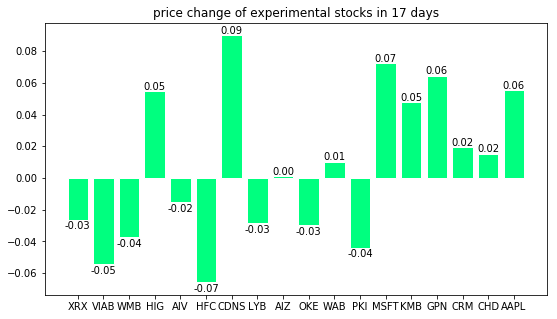

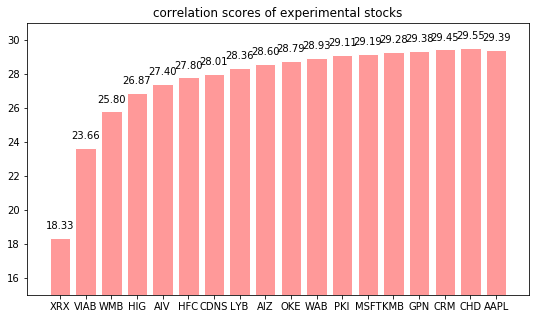

In [63]:
plot_price_change(rf_df)
plot_corr(rf_df)

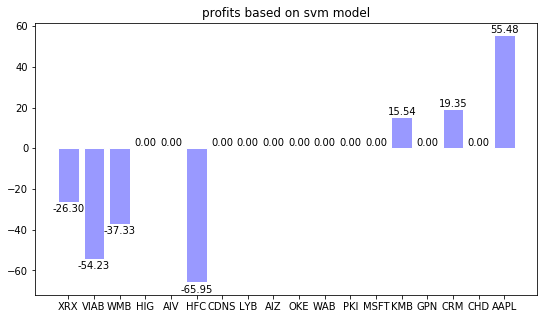

<Figure size 432x288 with 0 Axes>

In [179]:
plot_profits(svm_df,'svm')
#plot_corr(svm_df)
#plot_price_change(svm_df)

In [ ]:
#train the knn model and return the df
knn = train_and_compile(experimental_tickers, 'knn')
knn_df = knn.T

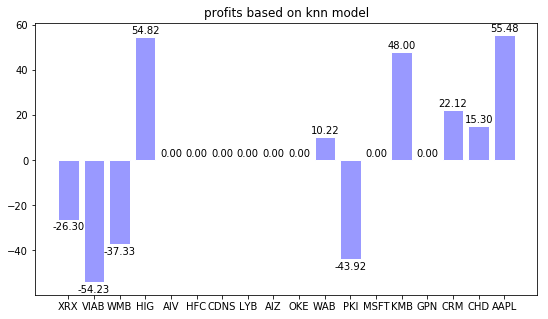

<Figure size 432x288 with 0 Axes>

In [181]:
plot_profits(knn_df, 'knn')

In [27]:
voting = train_and_compile(experimental_tickers, 'Voting')
voting_df = voting.T

data spread: Counter({'1': 2237, '-1': 2047, '0': 561})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'0': 1911, '1': 1522, '-1': 1412})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2356, '-1': 1994, '0': 495})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2143, '-1': 1847, '0': 855})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2151, '-1': 1645, '0': 1049})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2491, '-1': 2085, '0': 269})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2290, '-1': 1946, '0': 609})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'0': 2837, '1': 1157, '-1': 851})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'0': 1921, '1': 1645, '-1': 1279})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2320, '-1': 1698, '0': 827})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2374, '-1': 1914, '0': 557})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2270, '-1': 1869, '0': 706})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2032, '-1': 1777, '0': 1036})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'0': 1984, '1': 1581, '-1': 1280})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2198, '-1': 1643, '0': 1004})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 1863, '-1': 1574, '0': 1408})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 1923, '0': 1540, '-1': 1382})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2398, '-1': 1990, '0': 457})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


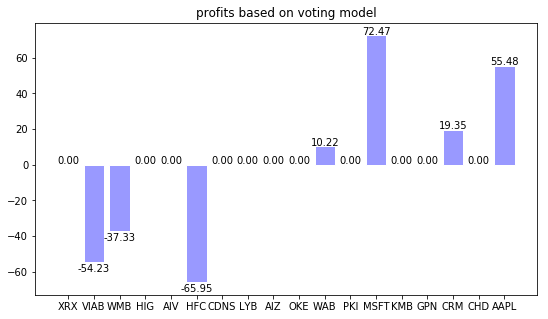

<Figure size 432x288 with 0 Axes>

In [28]:
plot_profits(voting_df, 'voting')

In [37]:
rf = train_and_compile(experimental_tickers, 'rf')
rf_df = rf.T

data spread: Counter({'1': 2237, '-1': 2047, '0': 561})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'0': 1911, '1': 1522, '-1': 1412})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2356, '-1': 1994, '0': 495})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2143, '-1': 1847, '0': 855})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2151, '-1': 1645, '0': 1049})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2491, '-1': 2085, '0': 269})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2290, '-1': 1946, '0': 609})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'0': 2837, '1': 1157, '-1': 851})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'0': 1921, '1': 1645, '-1': 1279})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2320, '-1': 1698, '0': 827})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2374, '-1': 1914, '0': 557})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2270, '-1': 1869, '0': 706})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2032, '-1': 1777, '0': 1036})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'0': 1984, '1': 1581, '-1': 1280})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2198, '-1': 1643, '0': 1004})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 1863, '-1': 1574, '0': 1408})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 1923, '0': 1540, '-1': 1382})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data spread: Counter({'1': 2398, '-1': 1990, '0': 457})


C:\Users\ow7ks\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


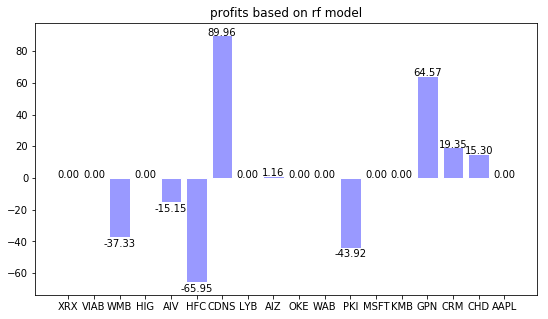

<Figure size 432x288 with 0 Axes>

In [38]:
plot_profits(rf_df,'rf')

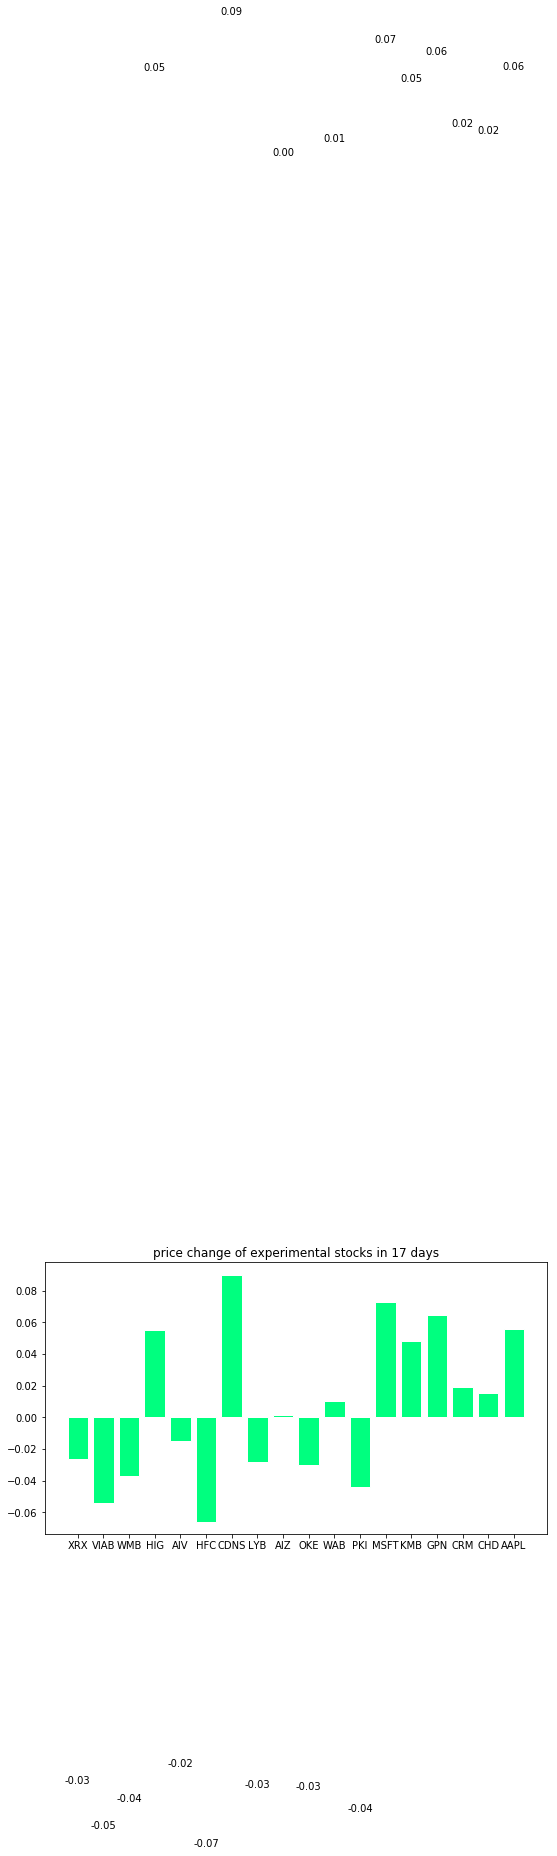

In [46]:
plot_price_change(rf_df)

actual spread: Counter({1: 503, -1: 389, 0: 320})
